# Demo 5: Multi-Strategy Customer Segmentation

This notebook compares three customer segmentation approaches:
1. **Cohort Analysis**
2. **Churn Prediction Model**
3. **Latent Trait Personas via PCA**

Each method is applied to the same e-commerce dataset to illustrate different segmentation strategies and their business applications.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta


## Load and Clean Dataset

In [2]:
# Load Excel or CSV dataset
df = pd.read_excel('/Users/jacquelinehardy/Desktop/jh-data-studio-demos/demo-05-multistrategy-segmentation/data/Online Retail.xlsx')

# Cleaning Strategy (as in Demo 1)
df_clean = df.dropna(subset=['CustomerID'])
df_clean = df_clean[df_clean['Quantity'] >= 0]
df_clean = df_clean.drop_duplicates()

excluded_rows = df.shape[0] - df_clean.shape[0]
excluded_pct = round((excluded_rows / df.shape[0]) * 100, 2)
print(f"{excluded_rows} rows removed ({excluded_pct}% of original data).")

# Additional preprocessing
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_clean['InvoiceMonth'] = df_clean['InvoiceDate'].dt.to_period('M')


149177 rows removed (27.53% of original data).


## Part 1: Cohort Analysis

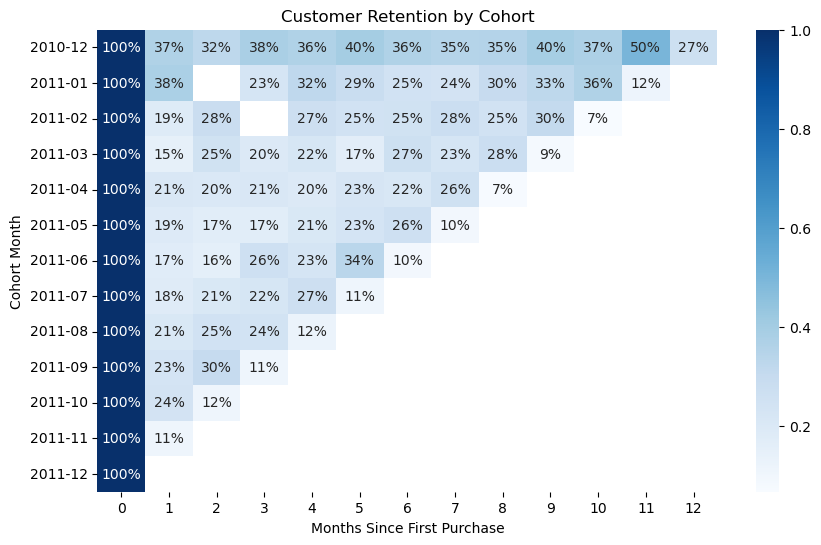

In [3]:
df_clean['CohortMonth'] = df_clean.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
df_clean['CohortIndex'] = (df_clean['InvoiceMonth'].dt.to_timestamp() - df_clean['CohortMonth'].dt.to_timestamp()).dt.days // 30

cohort_data = df_clean.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

cohort_size = cohort_pivot.iloc[:,0]
retention = cohort_pivot.divide(cohort_size, axis=0).round(3)

plt.figure(figsize=(10,6))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='Blues')
plt.title("Customer Retention by Cohort")
plt.ylabel("Cohort Month")
plt.xlabel("Months Since First Purchase")
plt.show()


## Part 2: Churn Prediction

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

snapshot_date = df_clean['InvoiceDate'].max() + timedelta(days=1)
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': [lambda x: (snapshot_date - x.max()).days,
                    lambda x: (x.max() - x.min()).days],
    'InvoiceNo': 'count',
    'TotalPrice': 'sum'
})
rfm.columns = ['Recency', 'Tenure', 'Frequency', 'Monetary']
rfm = rfm[rfm['Monetary'] > 0]

rfm['Churn'] = (rfm['Recency'] > 90).astype(int)

X = rfm[['Recency', 'Tenure', 'Frequency', 'Monetary']]
y = rfm['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       865
           1       1.00      1.00      1.00       437

    accuracy                           1.00      1302
   macro avg       1.00      1.00      1.00      1302
weighted avg       1.00      1.00      1.00      1302

ROC AUC Score: 1.0


### Alternate Churn Prediction (Realistic Evaluation)
To avoid an overfitted or overly perfect model, stratified sampling and cross-validation is used below to evaluate generalizability. This provides a more realistic estimate of model performance.

In [6]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Stratified K-Fold CV for ROC AUC
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')

print("Cross-Validated ROC AUC Scores:", np.round(cv_scores, 3))
print("Mean ROC AUC Score:", round(np.mean(cv_scores), 3))

Cross-Validated ROC AUC Scores: [1. 1. 1. 1. 1.]
Mean ROC AUC Score: 1.0


## **Note on Perfect Model Performance**  
Despite applying stratified cross-validation, the model achieves a perfect ROC AUC of 1.0 across all folds.  
This indicates that the target variable ("churn") is extremely well-separated from the features — particularly `Recency`, which almost deterministically predicts churn.  

While such separation is rare in real-world datasets, this highlights the value of clean, well-structured behavioral data. In practice, one would validate such findings on a more complex, noisier dataset before deployment.


## Part 3: Latent Trait Personas with PCA

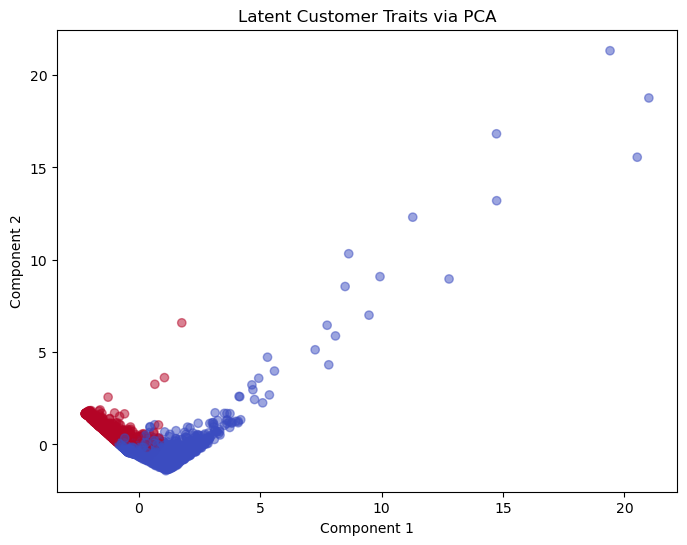

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=rfm['Churn'], cmap='coolwarm', alpha=0.5)
plt.title("Latent Customer Traits via PCA")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


## Summary: Comparing Segmentation Methods


| Method           | Pros                          | Cons                         | Best Use Case                     |
|------------------|-------------------------------|-------------------------------|------------------------------------|
| Cohort           | Easy to interpret, retention-focused | Misses individual variation | Lifecycle marketing, LTV modeling  |
| Churn Prediction | Predictive, actionable        | Needs label, some modeling   | Win-back campaigns, risk targeting |
| Latent Personas  | Unsupervised, exploratory     | Harder to explain segments   | UX, personalization, discovery     |

**Recommendation**: Choose the method based on the business question:
- Use **cohort** when analyzing lifecycle/retention
- Use **churn model** when targeting actions
- Use **PCA or clustering** to explore unknown customer behaviors
